## 한글 ↔ 영어 매핑
- 경제적 피해 → `economic_victim`
- 성적 피해 → `sexual_victim`
- 신체적 피해 → `physical_victim`
- 정서적 피해 → `psychological_victim`
- 남성 → `male`
- 여성 → `female`
- (경찰청) 신고 건수 → `report` / `police_domestic_violence_reports_by_region.csv`
- (경찰청) 검거·조치 → `action` / `police_domestic_violence_arrests_and_measures.csv`
- (경찰청) 검거·재범률 → `arrest_re` / `domestic_violence_arrests_and_recidivism_rate.xlsx`


# 공통 셋업

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os, glob, re, numpy as np, pandas as pd
pd.options.display.max_columns = 120

ROOT  = "/content/drive/MyDrive/text/violence-news-frame-analysis"
RAW   = f"{ROOT}/raw_data"
OUT_P = f"{ROOT}/processed_data"
os.makedirs(OUT_P, exist_ok=True)

print("ROOT :", ROOT)
print("RAW  :", RAW)
print("OUT_P:", OUT_P)

Mounted at /content/drive
ROOT : /content/drive/MyDrive/text/violence-news-frame-analysis
RAW  : /content/drive/MyDrive/text/violence-news-frame-analysis/raw_data
OUT_P: /content/drive/MyDrive/text/violence-news-frame-analysis/processed_data


In [ ]:
def list_xlsx(sub):
    files = []
    for pat in ("*.xlsx","*.XLSX","*.xls","*.XLS"):
        files += glob.glob(os.path.join(RAW, sub, pat))
    return sorted(files)

TYPE_MAP = {"economic":"economic","sexual":"sexual","physical":"physical","psychological":"psychological",
            "경제":"economic","성적":"sexual","신체":"physical","정서":"psychological"}

def detect_type(fn):
    low = fn.lower()
    for k,v in TYPE_MAP.items():
        if k in low or k in fn: return v
    return "unknown"

def detect_sex(fn):
    low = fn.lower()
    if ("female" in low) or ("여성" in fn) or ("여_" in fn): return "female"
    if ("male"   in low) or ("남성" in fn) or ("남_" in fn): return "male"
    if ("total"  in low) or ("전체" in fn):                  return "total"
    return "unknown"

def detect_year(fn):
    m = re.search(r"(20\d{2})", fn)
    return m.group(1) if m else ""

def safe_save_csv(df, path, encoding="utf-8"):
    base, ext = os.path.splitext(path)
    i, final = 0, path
    while os.path.exists(final):
        i += 1
        final = f"{base}__v{i}{ext}"
    df.to_csv(final, index=False, encoding=encoding)
    return final

def tidy_kosis_excel(path:str) -> pd.DataFrame:
    df = pd.read_excel(path)

    for c in ['시점','경험별(1)','경험별(2)']:
        if c in df.columns: df[c] = df[c].ffill()

    if '경험별(1)' in df.columns:
        df = df[df['경험별(1)'].astype(str).str.contains('지난 1년', na=False)]
    if '경험별(2)' in df.columns:
        df = df[df['경험별(2)'].astype(str).str.contains('폭력 있음', na=False)]

    meta_cols  = [c for c in ['시점','경험별(1)','경험별(2)'] if c in df.columns]
    value_cols = [c for c in df.columns if c not in meta_cols]

    if '시점' in df.columns and value_cols:
        long = df.melt(id_vars=['시점'], value_vars=value_cols,
                       var_name='item', value_name='value')
    else:
        keep = [c for c in ['시점','item','값','value'] if c in df.columns]
        long = df[keep].rename(columns={'값':'value'})

    long['value'] = (long['value'].astype(str)
                     .str.replace(',','', regex=False)
                     .str.replace('%','', regex=False)
                     .str.replace('명','', regex=False)
                     .str.replace('건','', regex=False))
    long['value'] = pd.to_numeric(long['value'].str.extract(r'(\d+\.?\d*)')[0], errors='coerce')
    long = long.dropna(subset=['value'])

    long = long.rename(columns={'시점':'year'})
    if 'year' in long.columns:
        long['year'] = long['year'].astype(str).str.extract(r'(20\d{2})')

    fn = os.path.basename(path)
    long['file'] = fn
    long['type'] = detect_type(fn)
    long['sex']  = detect_sex(fn)
    long['year'] = long['year'].fillna(detect_year(fn))

    long['type'] = pd.Categorical(long['type'],
        categories=['economic','sexual','physical','psychological'], ordered=True)
    long['sex'] = pd.Categorical(long['sex'],
        categories=['male','female','total'], ordered=True)

    return long[['year','type','sex','item','value','file']]

# 4가지 피해 파일들 전처리 & 개별 저장

In [ ]:
SUBFOLDER = "economic_victim"

paths = list_xlsx(SUBFOLDER)
print(SUBFOLDER, "파일:", [os.path.basename(p) for p in paths])

dfs = []
for p in paths:
    try:
        df = tidy_kosis_excel(p)
        dfs.append(df)
        print("OK:", os.path.basename(p), df.shape)
    except Exception as e:
        print("FAIL:", p, "→", e)

assert dfs, "이 폴더에서 읽은 데이터가 없습니다."
tidy = (pd.concat(dfs, ignore_index=True)
        .sort_values(['type','sex','item','year'])
        .reset_index(drop=True))

out_path = os.path.join(OUT_P, f"victim_tidy_{SUBFOLDER}.csv")
saved_to = safe_save_csv(tidy, out_path, encoding="utf-8")
print("saved:", saved_to)

display(tidy.head(10))

economic_victim 파일: ['economic_victim_female_2022.xlsx', 'economic_victim_male_2022.xlsx']


/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


OK: economic_victim_female_2022.xlsx (4, 6)
OK: economic_victim_male_2022.xlsx (2, 6)
saved: /content/drive/MyDrive/text/violence-news-frame-analysis/processed_data/victim_tidy_economic_victim__v1.csv


/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,year,type,sex,item,value,file
0,2022,economic,male,상대방이 생활비를 부담해야 하지만 일부러 생활비를 주지 않았다,0.1,economic_victim_male_2022.xlsx
1,2022,economic,male,수입과 지출을 독점하였다,0.2,economic_victim_male_2022.xlsx
2,2022,economic,female,나의 돈이나 재산을 빼앗거나 빚을 지게 하였다,0.1,economic_victim_female_2022.xlsx
3,2022,economic,female,나의 재산 또는 나에게 지분이 있는 재산을 동의 없이 처분했다,0.2,economic_victim_female_2022.xlsx
4,2022,economic,female,상대방이 생활비를 부담해야 하지만 일부러 생활비를 주지 않았다,0.4,economic_victim_female_2022.xlsx
5,2022,economic,female,수입과 지출을 독점하였다,0.3,economic_victim_female_2022.xlsx


In [ ]:
SUBFOLDER = "sexual_victim"

paths = list_xlsx(SUBFOLDER)
print(SUBFOLDER, "파일:", [os.path.basename(p) for p in paths])

dfs = []
for p in paths:
    try:
        df = tidy_kosis_excel(p)
        dfs.append(df)
        print("OK:", os.path.basename(p), df.shape)
    except Exception as e:
        print("FAIL:", p, "→", e)

assert dfs, "이 폴더에서 읽은 데이터가 없습니다."
tidy = (pd.concat(dfs, ignore_index=True)
        .sort_values(['type','sex','item','year'])
        .reset_index(drop=True))

out_path = os.path.join(OUT_P, f"victim_tidy_{SUBFOLDER}.csv")
saved_to = safe_save_csv(tidy, out_path, encoding="utf-8")
print("saved:", saved_to)

display(tidy.head(10))

sexual_victim 파일: ['sexual_victim_female_2022.xlsx', 'sexual_victim_male_2022.xlsx']


/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


OK: sexual_victim_female_2022.xlsx (26, 6)
OK: sexual_victim_male_2022.xlsx (22, 6)
saved: /content/drive/MyDrive/text/violence-news-frame-analysis/processed_data/victim_tidy_sexual_victim__v1.csv


/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,year,type,sex,item,value,file
0,2022,sexual,male,경험별(3),1.0,sexual_victim_male_2022.xlsx
1,2022,sexual,male,경험별(3),1.0,sexual_victim_male_2022.xlsx
2,2022,sexual,male,경험별(3),2.0,sexual_victim_male_2022.xlsx
3,2022,sexual,male,경험별(3),1.0,sexual_victim_male_2022.xlsx
4,2022,sexual,male,나의 신체 일부 또는 성행위를 동의 없이 촬영하였다,0.1,sexual_victim_male_2022.xlsx
5,2022,sexual,male,나의 신체 일부 또는 성행위를 동의 없이 촬영하였다,0.0,sexual_victim_male_2022.xlsx
6,2022,sexual,male,나의 신체 일부 또는 성행위를 동의 없이 촬영하였다,0.1,sexual_victim_male_2022.xlsx
7,2022,sexual,male,"나의 신체 일부 또는 성행위를 촬영한 사진, 동영상, 나의 이미지를 이용한 성적 합...",0.1,sexual_victim_male_2022.xlsx
8,2022,sexual,male,"나의 신체 일부 또는 성행위를 촬영한 사진, 동영상, 나의 이미지를 이용한 성적 합...",0.0,sexual_victim_male_2022.xlsx
9,2022,sexual,male,"나의 신체 일부 또는 성행위를 촬영한 사진, 동영상, 나의 이미지를 이용한 성적 합...",0.1,sexual_victim_male_2022.xlsx


In [ ]:
SUBFOLDER = "physical_victim"

paths = list_xlsx(SUBFOLDER)
print(SUBFOLDER, "파일:", [os.path.basename(p) for p in paths])

dfs = []
for p in paths:
    try:
        df = tidy_kosis_excel(p)
        dfs.append(df)
        print("OK:", os.path.basename(p), df.shape)
    except Exception as e:
        print("FAIL:", p, "→", e)

assert dfs, "이 폴더에서 읽은 데이터가 없습니다."
tidy = (pd.concat(dfs, ignore_index=True)
        .sort_values(['type','sex','item','year'])
        .reset_index(drop=True))

out_path = os.path.join(OUT_P, f"victim_tidy_{SUBFOLDER}.csv")
saved_to = safe_save_csv(tidy, out_path, encoding="utf-8")
print("saved:", saved_to)

display(tidy.head(10))

physical_victim 파일: ['physical_victim_female_2022.xlsx', 'physical_victim_male_2022.xlsx']


/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


OK: physical_victim_female_2022.xlsx (26, 6)
OK: physical_victim_male_2022.xlsx (19, 6)
saved: /content/drive/MyDrive/text/violence-news-frame-analysis/processed_data/victim_tidy_physical_victim__v1.csv


/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,year,type,sex,item,value,file
0,2022,physical,male,경험별(3),1.0,physical_victim_male_2022.xlsx
1,2022,physical,male,경험별(3),1.0,physical_victim_male_2022.xlsx
2,2022,physical,male,경험별(3),2.0,physical_victim_male_2022.xlsx
3,2022,physical,male,경험별(3),1.0,physical_victim_male_2022.xlsx
4,2022,physical,male,나를 다치게 할 수 있는 물건을 던졌다,0.3,physical_victim_male_2022.xlsx
5,2022,physical,male,나를 다치게 할 수 있는 물건을 던졌다,0.3,physical_victim_male_2022.xlsx
6,2022,physical,male,나를 다치게 할 수 있는 물건을 던졌다,0.0,physical_victim_male_2022.xlsx
7,2022,physical,male,목을 조르거나 코와 입을 막는 등 숨을 쉬지 못하게 하거나 고의로 화상을 입혔다,0.0,physical_victim_male_2022.xlsx
8,2022,physical,male,"밀치거나 팔, 어깨, 머리 등을 움켜잡았다",0.8,physical_victim_male_2022.xlsx
9,2022,physical,male,"밀치거나 팔, 어깨, 머리 등을 움켜잡았다",0.7,physical_victim_male_2022.xlsx


In [ ]:
SUBFOLDER = "psychological_victim"

paths = list_xlsx(SUBFOLDER)
print(SUBFOLDER, "파일:", [os.path.basename(p) for p in paths])

dfs = []
for p in paths:
    try:
        df = tidy_kosis_excel(p)
        dfs.append(df)
        print("OK:", os.path.basename(p), df.shape)
    except Exception as e:
        print("FAIL:", p, "→", e)

assert dfs, "이 폴더에서 읽은 데이터가 없습니다."
tidy = (pd.concat(dfs, ignore_index=True)
        .sort_values(['type','sex','item','year'])
        .reset_index(drop=True))

out_path = os.path.join(OUT_P, f"victim_tidy_{SUBFOLDER}.csv")
saved_to = safe_save_csv(tidy, out_path, encoding="utf-8")
print("saved:", saved_to)

display(tidy.head(10))

psychological_victim 파일: ['psychological_victim_female_2022.xlsx', 'psychological_victim_male_2022.xlsx']


/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


OK: psychological_victim_female_2022.xlsx (29, 6)
OK: psychological_victim_male_2022.xlsx (26, 6)
saved: /content/drive/MyDrive/text/violence-news-frame-analysis/processed_data/victim_tidy_psychological_victim__v1.csv


/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,year,type,sex,item,value,file
0,2022,psychological,male,경험별(3),1.0,psychological_victim_male_2022.xlsx
1,2022,psychological,male,경험별(3),1.0,psychological_victim_male_2022.xlsx
2,2022,psychological,male,경험별(3),2.0,psychological_victim_male_2022.xlsx
3,2022,psychological,male,경험별(3),1.0,psychological_victim_male_2022.xlsx
4,2022,psychological,male,나의 물건을 부쉈다,0.4,psychological_victim_male_2022.xlsx
5,2022,psychological,male,나의 물건을 부쉈다,0.3,psychological_victim_male_2022.xlsx
6,2022,psychological,male,나의 물건을 부쉈다,0.1,psychological_victim_male_2022.xlsx
7,2022,psychological,male,"내 앞에서 자해를 하거나 자해, 자살하겠다고 위협했다",0.2,psychological_victim_male_2022.xlsx
8,2022,psychological,male,"내 앞에서 자해를 하거나 자해, 자살하겠다고 위협했다",0.0,psychological_victim_male_2022.xlsx
9,2022,psychological,male,"내 앞에서 자해를 하거나 자해, 자살하겠다고 위협했다",0.2,psychological_victim_male_2022.xlsx


# 피해 4종 통합

In [ ]:
part_files = sorted(glob.glob(os.path.join(OUT_P, "victim_tidy_*_victim*.csv")))
print("발견된 부분 파일:", [os.path.basename(p) for p in part_files])

parts = [pd.read_csv(p) for p in part_files]
victim_all = (pd.concat(parts, ignore_index=True)
              .sort_values(['type','sex','item','year'])
              .reset_index(drop=True))

out_all = os.path.join(OUT_P, "victim_tidy_ALL.csv")
saved_all = safe_save_csv(victim_all, out_all, encoding="utf-8")
print("saved:", saved_all)

display(victim_all.head(12))
print(victim_all.groupby(['type','sex'])['value'].mean().round(3))

발견된 부분 파일: ['victim_tidy_economic_victim.csv', 'victim_tidy_economic_victim__v1.csv', 'victim_tidy_physical_victim.csv', 'victim_tidy_physical_victim__v1.csv', 'victim_tidy_psychological_victim.csv', 'victim_tidy_psychological_victim__v1.csv', 'victim_tidy_sexual_victim.csv', 'victim_tidy_sexual_victim__v1.csv']
saved: /content/drive/MyDrive/text/violence-news-frame-analysis/processed_data/victim_tidy_ALL__v1.csv


,year,type,sex,item,value,file
0,2022,economic,female,나의 돈이나 재산을 빼앗거나 빚을 지게 하였다,0.1,economic_victim_female_2022.xlsx
1,2022,economic,female,나의 돈이나 재산을 빼앗거나 빚을 지게 하였다,0.1,economic_victim_female_2022.xlsx
2,2022,economic,female,나의 재산 또는 나에게 지분이 있는 재산을 동의 없이 처분했다,0.2,economic_victim_female_2022.xlsx
3,2022,economic,female,나의 재산 또는 나에게 지분이 있는 재산을 동의 없이 처분했다,0.2,economic_victim_female_2022.xlsx
4,2022,economic,female,상대방이 생활비를 부담해야 하지만 일부러 생활비를 주지 않았다,0.4,economic_victim_female_2022.xlsx
5,2022,economic,female,상대방이 생활비를 부담해야 하지만 일부러 생활비를 주지 않았다,0.4,economic_victim_female_2022.xlsx
6,2022,economic,female,수입과 지출을 독점하였다,0.3,economic_victim_female_2022.xlsx
7,2022,economic,female,수입과 지출을 독점하였다,0.3,economic_victim_female_2022.xlsx
8,2022,economic,male,상대방이 생활비를 부담해야 하지만 일부러 생활비를 주지 않았다,0.1,economic_victim_male_2022.xlsx
9,2022,economic,male,상대방이 생활비를 부담해야 하지만 일부러 생활비를 주지 않았다,0.1,economic_victim_male_2022.xlsx


type           sex   
economic       female    0.250
               male      0.150
physical       female    0.358
               male      0.432
psychological  female    0.845
               male      0.700
sexual         female    0.612
               male      0.364
Name: value, dtype: float64


# 피해 4종 피벗 요약 생성

In [ ]:
pivot_us = (victim_all.groupby(['type','sex'])['value'].mean()
            .unstack('sex')
            .reindex(['economic','sexual','physical','psychological']))

pivot_us['gap_f_minus_m']  = pivot_us['female'] - pivot_us['male']
pivot_us['ratio_f_over_m'] = pivot_us['female'] / pivot_us['male']

pivot_csv = os.path.join(OUT_P, "victim_pivot_from_parts.csv")
pivot_us.to_csv(pivot_csv, encoding="utf-8")
print("saved:", pivot_csv)

display(pivot_us.round(3))

saved: /content/drive/MyDrive/text/violence-news-frame-analysis/processed_data/victim_pivot_from_parts.csv


sex,female,male,gap_f_minus_m,ratio_f_over_m
type,,,,
economic,0.250,0.150,0.100,1.667
sexual,0.612,0.364,0.248,1.682
physical,0.358,0.432,-0.074,0.829
psychological,0.845,0.700,0.145,1.207


# 경찰청 행정자료 셋업

In [ ]:
import os, re, glob, pandas as pd, numpy as np
pd.options.display.max_columns = 120

ROOT  = "/content/drive/MyDrive/text/violence-news-frame-analysis"
RAW   = f"{ROOT}/raw_data"
OUT_P = f"{ROOT}/processed_data"
os.makedirs(OUT_P, exist_ok=True)

def safe_save_csv(df, path, encoding="utf-8"):
    base, ext = os.path.splitext(path)
    i, final = 0, path
    while os.path.exists(final):
        i += 1
        final = f"{base}__v{i}{ext}"
    df.to_csv(final, index=False, encoding=encoding)
    return final

def read_any(path):
    ext = os.path.splitext(path)[1].lower()
    if ext in [".xlsx", ".xls"]:
        return pd.read_excel(path)
    for enc in ["utf-8-sig","utf-8","cp949","euc-kr"]:
        try:
            return pd.read_csv(path, encoding=enc)
        except Exception:
            continue
    return pd.read_csv(path, errors="ignore")

# 신고 건수 전처리 및 저장

In [ ]:
import os, pandas as pd, numpy as np, re

path_report = os.path.join(RAW, "report", "police_domestic_violence_reports_by_region.csv")
report = read_any(path_report).copy()

colmap = {}
for c in report.columns:
    s = str(c)
    if re.search(r"^연?도?$|year", s, re.I): colmap[c] = "year"
    elif re.search(r"시\s*도|region|광역|지역", s, re.I): colmap[c] = "region"

report = report.rename(columns=colmap)

value_cols = [c for c in report.columns if c not in ["year","region"]]
rep_long = report.melt(id_vars=[c for c in ["year","region"] if c in report.columns],
                       value_vars=value_cols, var_name="item", value_name="value")

rep_long["value"] = (rep_long["value"].astype(str)
                     .str.replace(",","", regex=False)
                     .str.extract(r"(\d+\.?\d*)")[0])
rep_long["value"] = pd.to_numeric(rep_long["value"], errors="coerce")
rep_long = rep_long.dropna(subset=["value"]).copy()

rep_long["metric"] = "reports"

rep_long["year"] = rep_long["year"].astype(str).str.extract(r"(20\d{2})")

out_report = os.path.join(OUT_P, "report_tidy.csv")
saved = safe_save_csv(rep_long, out_report)
print("saved:", saved)
rep_long.head(10)

saved: /content/drive/MyDrive/text/violence-news-frame-analysis/processed_data/report_tidy__v1.csv


,year,item,value,metric
0,2021,서울,38826,reports
1,2022,서울,40853,reports
2,2023,서울,40488,reports
3,2024,서울,41657,reports
4,2021,부산,11912,reports
5,2022,부산,12602,reports
6,2023,부산,12662,reports
7,2024,부산,15501,reports
8,2021,대구,10841,reports
9,2022,대구,11560,reports


# 검거 조치 전처리 및 저장

In [ ]:
path_action = os.path.join(RAW, "action", "police_domestic_violence_arrests_and_measures.csv")
action = read_any(path_action).copy()

colmap = {}
for c in action.columns:
    s = str(c)
    if re.search(r"^연?도?$|year", s, re.I): colmap[c] = "year"
action = action.rename(columns=colmap)

id_vars = [c for c in ["year"] if c in action.columns]
val_vars = [c for c in action.columns if c not in id_vars]

act_long = action.melt(id_vars=id_vars, value_vars=val_vars,
                       var_name="item", value_name="value")

act_long["value"] = (act_long["value"].astype(str)
                     .str.replace(",","", regex=False)
                     .str.replace("%","", regex=False)
                     .str.extract(r"(\d+\.?\d*)")[0])
act_long["value"] = pd.to_numeric(act_long["value"], errors="coerce")
act_long = act_long.dropna(subset=["value"]).copy()
act_long["year"] = act_long["year"].astype(str).str.extract(r"(20\d{2})")

def tag_action(item:str)->str:
    s=item.lower()
    if any(k in s for k in ["구속","불구속","검거","arrest"]): return "arrests"
    if any(k in s for k in ["조치","보호","measures","protect"]): return "measures"
    return "arrests_measures_other"

act_long["metric"] = act_long["item"].astype(str).apply(tag_action)

out_action = os.path.join(OUT_P, "action_tidy.csv")
saved = safe_save_csv(act_long, out_action)
print("saved:", saved)
act_long.head(10)

saved: /content/drive/MyDrive/text/violence-news-frame-analysis/processed_data/action_tidy__v1.csv


,year,item,value,metric
0,2017,검거건수,38583,arrests
1,2018,검거건수,41905,arrests
2,2019,검거건수,50277,arrests
3,2020,검거건수,44459,arrests
4,2021,검거건수,46041,arrests
5,2022,검거건수,44816,arrests
6,2023,검거건수,44524,arrests
7,2024,검거건수,37905,arrests
8,2017,검거총인원,45264,arrests
9,2018,검거총인원,43576,arrests


# 검거 재범률 전처리 및 저장

In [ ]:
import re, pandas as pd, numpy as np, os

def tidy_arrest_re(path):
    df = read_any(path).copy()

    if isinstance(df.columns, pd.MultiIndex):
        df.columns = ['_'.join([str(x) for x in tup if pd.notna(x)]).strip()
                      for tup in df.columns]

    df = df.dropna(how='all').dropna(axis=1, how='all')

    year_col = None
    for c in df.columns:
        s = str(c)
        if re.search(r'(연도|년도|시점|year)', s, re.I):
            year_col = c
            break

    if year_col is None:
        for c in df.columns:
            vals = df[c].astype(str)
            if vals.str.contains(r'20\d{2}').any():
                year_col = c
                break

    if year_col is None:
        idx_vals = pd.Series(df.index.astype(str))
        if idx_vals.str.contains(r'20\d{2}').any():
            df = df.reset_index().rename(columns={'index':'year'})
            year_col = 'year'

    if year_col is None:
        df['year'] = ''
        year_col = 'year'
    df['year'] = df[year_col].astype(str).str.extract(r'(20\d{2})')

    value_cols = [c for c in df.columns if c != 'year']
    long = df.melt(id_vars=['year'], value_vars=value_cols,
                   var_name='item', value_name='value')

    long['value'] = (long['value'].astype(str)
                     .str.replace(',','', regex=False)
                     .str.replace('%','', regex=False)
                     .str.extract(r'(\d+\.?\d*)')[0])
    long['value'] = pd.to_numeric(long['value'], errors='coerce')
    long = long.dropna(subset=['value']).copy()

    def tag_re(item:str)->str:
        s=item.lower()
        if any(k in s for k in ['재범','recidiv']): return 'recidivism_rate'
        if any(k in s for k in ['검거','arrest']):  return 'arrests'
        return 'arrests_re_other'
    long['metric'] = long['item'].astype(str).apply(tag_re)

    return long[['year','item','metric','value']]

path_re = os.path.join(RAW, "arrest_re", "domestic_violence_arrests_and_recidivism_rate.xlsx")
re_long = tidy_arrest_re(path_re)

out_re = os.path.join(OUT_P, "arrest_re_tidy.csv")
saved = safe_save_csv(re_long, out_re)
print("saved:", saved)
display(re_long.head(10))

saved: /content/drive/MyDrive/text/violence-news-frame-analysis/processed_data/arrest_re_tidy__v1.csv


/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,year,item,metric,value
8,NaN,2021,arrests_re_other,46041.0
9,NaN,2021,arrests_re_other,53985.0
10,NaN,2021,arrests_re_other,13209.0
11,NaN,2021,arrests_re_other,40776.0
12,NaN,2022,arrests_re_other,44816.0
13,NaN,2022,arrests_re_other,52146.0
14,NaN,2022,arrests_re_other,12760.0
15,NaN,2022,arrests_re_other,39386.0
16,NaN,2023,arrests_re_other,44524.0
17,NaN,2023,arrests_re_other,55176.0


# 경찰청 3종 합치기

In [ ]:
parts = []
for name in ["report_tidy.csv","action_tidy.csv","arrest_re_tidy.csv"]:
    p = os.path.join(OUT_P, name)
    if os.path.exists(p):
        df = pd.read_csv(p)
        df["source"] = name.replace("_tidy.csv","")
        parts.append(df)
    else:
        print("⚠️ not found:", p)

police_all = (pd.concat(parts, ignore_index=True)
              .sort_values(["year","source","metric","item"])
              .reset_index(drop=True))

out_police = os.path.join(OUT_P, "police_all_tidy.csv")
saved = safe_save_csv(police_all, out_police)
print("saved:", saved)
display(police_all.head(12))

saved: /content/drive/MyDrive/text/violence-news-frame-analysis/processed_data/police_all_tidy__v1.csv


,year,item,value,metric,source
0,2017.0,검거건수,38583.0,arrests,action
1,2017.0,검거총인원,45264.0,arrests,action
2,2017.0,구속인원,384.0,arrests,action
3,2017.0,불구속인원,44880.0,arrests,action
4,2017.0,가정보호사건 송치,15979.0,measures,action
5,2018.0,검거건수,41905.0,arrests,action
6,2018.0,검거총인원,43576.0,arrests,action
7,2018.0,구속인원,355.0,arrests,action
8,2018.0,불구속인원,43221.0,arrests,action
9,2018.0,가정보호사건 송치,14689.0,measures,action


# 피해 데이터 4가지 re요약

In [ ]:
victim_wide = (victim_all
               .pivot_table(index="year",
                            columns=["type","sex"],
                            values="value",
                            aggfunc="mean")
               .sort_index())


victim_wide.columns = [f"victim_{t}_{s}" for t,s in victim_wide.columns]
victim_wide = victim_wide.reset_index()

display(victim_wide.head())

,year,victim_economic_female,victim_economic_male,victim_physical_female,victim_physical_male,victim_psychological_female,victim_psychological_male,victim_sexual_female,victim_sexual_male
0,2022,0.25,0.15,0.357692,0.431579,0.844828,0.7,0.611538,0.363636


# 경찰청 데이터 3가지 요약

In [ ]:
police_wide = (police_all
               .pivot_table(index="year",
                            columns="metric",
                            values="value",
                            aggfunc="sum")
               .sort_index()
               .reset_index())

police_wide = police_wide.rename(columns={c: f"police_{c}" for c in police_wide.columns if c!="year"})

display(police_wide.head())

metric,year,police_arrests,police_measures,police_reports
0,2017.0,129111.0,15979.0,NaN
1,2018.0,129057.0,14689.0,NaN
2,2019.0,169221.0,21228.0,NaN
3,2020.0,149321.0,19379.0,NaN
4,2021.0,154011.0,24867.0,218680.0


# 맥북 전용 한글 코드

In [ ]:
!pip install koreanize-matplotlib
import koreanize_matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 63.5 MB/s eta 0:00:00


# 피해 시각화 (2022)

In [ ]:
import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

ROOT = "/content/drive/MyDrive/text/violence-news-frame-analysis"
OUTDIR = os.path.join(ROOT, "processed_data")
os.makedirs(OUTDIR, exist_ok=True)

if 'victim_all' not in globals():
    cand = [
        os.path.join(OUTDIR, "victim_tidy.csv"),
        os.path.join(OUTDIR, "victim_tidy_ALL.csv"),
        os.path.join(OUTDIR, "kosis_partner_victim_2022_tidy.csv"),  # 네가 저장한 이름일 수도 있어
    ]
    path = next((p for p in cand if os.path.exists(p)), None)
    assert path is not None, "victim_all 이 없고, processed_data에 피해 전처리 csv도 못 찾았어."
    victim_all = pd.read_csv(path)

victim_all["year"] = (victim_all["year"].astype(str).str.extract(r"(20\d{2})")[0]).astype(float)

victim_2022 = victim_all[victim_all["year"] == 2022].copy()
assert len(victim_2022) > 0, "피해 데이터에서 2022년 행을 못 찾았어. 연도 정규화를 다시 확인해줘."

victim_wide = (victim_2022
               .pivot_table(index="year", columns=["type","sex"], values="value", aggfunc="mean")
               .sort_index())
victim_wide.columns = [f"victim_{t}_{s}" for t,s in victim_wide.columns]
victim_wide = victim_wide.reset_index()

display(victim_wide)


victim_wide_csv = os.path.join(OUTDIR, "victim_2022_wide.csv")
victim_wide.to_csv(victim_wide_csv, index=False, encoding="utf-8")
print("saved:", victim_wide_csv)

,year,victim_economic_female,victim_economic_male,victim_physical_female,victim_physical_male,victim_psychological_female,victim_psychological_male,victim_sexual_female,victim_sexual_male
0,2022.0,0.25,0.15,0.357692,0.431579,0.844828,0.7,0.611538,0.363636


saved: /content/drive/MyDrive/text/violence-news-frame-analysis/processed_data/victim_2022_wide.csv


# 1) 유형별 성별 막대 그래프

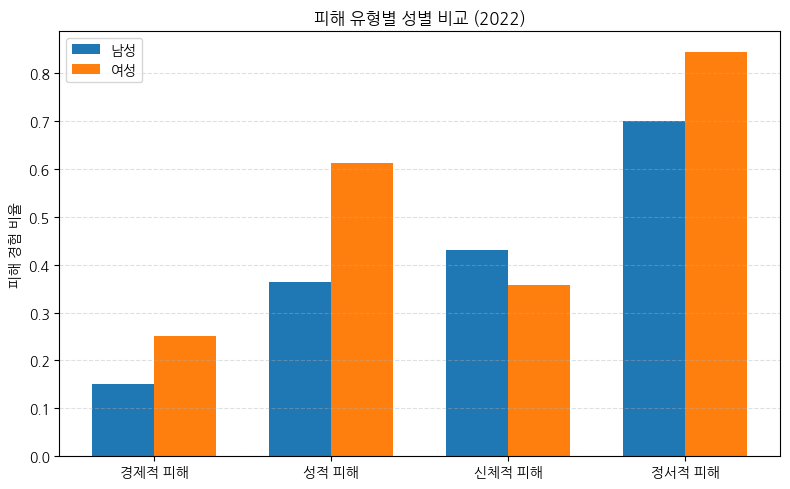

저장됨: /content/drive/MyDrive/text/violence-news-frame-analysis/processed_data/victim_2022_bar_type_sex.png


In [ ]:
bar_df = (victim_2022
          .groupby(["type","sex"])["value"].mean()
          .reset_index())

type_order = ["economic","sexual","physical","psychological"]
sex_order  = ["female","male"]

bar_df["type"] = pd.Categorical(bar_df["type"], categories=type_order, ordered=True)
bar_df["sex"]  = pd.Categorical(bar_df["sex"],  categories=sex_order,  ordered=True)
bar_df = bar_df.sort_values(["type","sex"])

plt.figure(figsize=(8,5))
x = np.arange(len(type_order))
w = 0.35

m_vals = bar_df[bar_df["sex"]=="male"]["value"].values
f_vals = bar_df[bar_df["sex"]=="female"]["value"].values

plt.bar(x - w/2, m_vals, width=w, label="남성")
plt.bar(x + w/2, f_vals, width=w, label="여성")

plt.xticks(x, ["경제적 피해","성적 피해","신체적 피해","정서적 피해"])
plt.ylabel("피해 경험 비율")
plt.title("피해 유형별 성별 비교 (2022)")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.4)

out_png = os.path.join(OUTDIR, "victim_2022_bar_type_sex.png")
plt.tight_layout()
plt.savefig(out_png, dpi=150)
plt.show()
print("저장됨:", out_png)

# 2) 히트맵

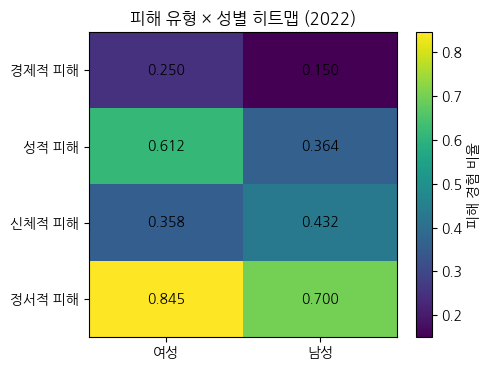

저장됨: /content/drive/MyDrive/text/violence-news-frame-analysis/processed_data/victim_2022_heatmap.png


In [ ]:
hm = (victim_2022
      .groupby(["type","sex"])["value"].mean()
      .unstack("sex")
      .reindex(type_order)[sex_order])

plt.figure(figsize=(5,3.8))
plt.imshow(hm.values, aspect="auto")
plt.colorbar(label="피해 경험 비율")
plt.xticks(range(len(hm.columns)), ["여성","남성"])
plt.yticks(range(len(hm.index)), ["경제적 피해","성적 피해","신체적 피해","정서적 피해"])
plt.title("피해 유형 × 성별 히트맵 (2022)")

for i in range(hm.shape[0]):
    for j in range(hm.shape[1]):
        plt.text(j, i, f"{hm.values[i,j]:.3f}", ha="center", va="center")

out_png = os.path.join(OUTDIR, "victim_2022_heatmap.png")
plt.tight_layout()
plt.savefig(out_png, dpi=150)
plt.show()
print("저장됨:", out_png)

# 3) 성별 격차/비율

sex,female,male,gap_f_minus_m,ratio_f_over_m
type,,,,
economic,0.250,0.150,0.100,1.667
sexual,0.612,0.364,0.248,1.682
physical,0.358,0.432,-0.074,0.829
psychological,0.845,0.700,0.145,1.207


saved: /content/drive/MyDrive/text/violence-news-frame-analysis/processed_data/victim_2022_gap_ratio.csv


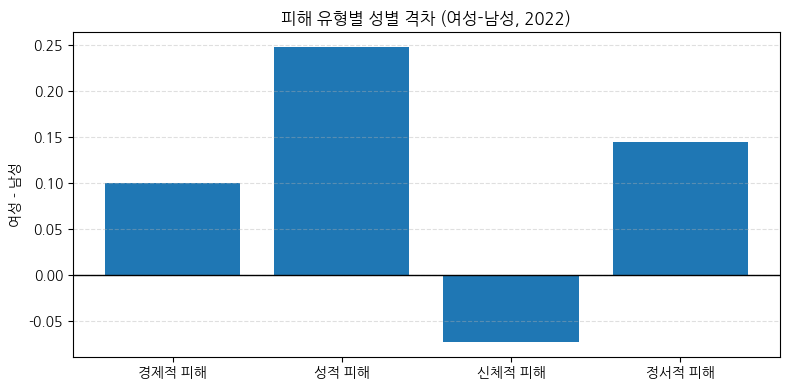

저장됨: /content/drive/MyDrive/text/violence-news-frame-analysis/processed_data/victim_2022_gap_bar.png


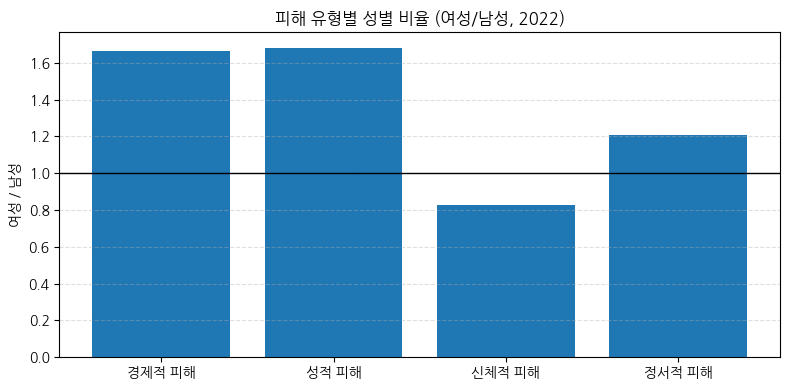

저장됨: /content/drive/MyDrive/text/violence-news-frame-analysis/processed_data/victim_2022_ratio_bar.png


In [ ]:
gap_df = (victim_2022
          .groupby(["type","sex"])["value"].mean()
          .unstack("sex")
          .reindex(type_order))

gap_df["gap_f_minus_m"] = gap_df["female"] - gap_df["male"]
gap_df["ratio_f_over_m"] = gap_df["female"] / gap_df["male"]

display(gap_df[["female","male","gap_f_minus_m","ratio_f_over_m"]].round(3))

gap_csv = os.path.join(OUTDIR, "victim_2022_gap_ratio.csv")
gap_df.to_csv(gap_csv, encoding="utf-8")
print("saved:", gap_csv)

plt.figure(figsize=(8,4))
plt.bar(gap_df.index, gap_df["gap_f_minus_m"])
plt.axhline(0, color="black", linewidth=1)
plt.ylabel("여성 - 남성")
plt.title("피해 유형별 성별 격차 (여성-남성, 2022)")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.xticks(range(len(gap_df.index)), ["경제적 피해","성적 피해","신체적 피해","정서적 피해"])
out_png = os.path.join(OUTDIR, "victim_2022_gap_bar.png")
plt.tight_layout()
plt.savefig(out_png, dpi=150)
plt.show()
print("저장됨:", out_png)

plt.figure(figsize=(8,4))
plt.bar(gap_df.index, gap_df["ratio_f_over_m"])
plt.axhline(1.0, color="black", linewidth=1)
plt.ylabel("여성 / 남성")
plt.title("피해 유형별 성별 비율 (여성/남성, 2022)")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.xticks(range(len(gap_df.index)), ["경제적 피해","성적 피해","신체적 피해","정서적 피해"])
out_png = os.path.join(OUTDIR, "victim_2022_ratio_bar.png")
plt.tight_layout()
plt.savefig(out_png, dpi=150)
plt.show()
print("저장됨:", out_png)

# 경찰청 시각화 (2021)

# 1) 전국: 신고·검거·조치(합계)


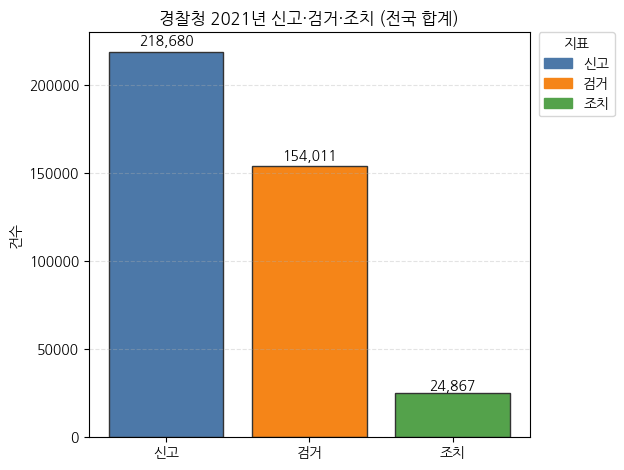

저장됨: /content/drive/MyDrive/text/violence-news-frame-analysis/processed_data/police_2021_national_counts.png


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

ROOT = "/content/drive/MyDrive/text/violence-news-frame-analysis"
OUT_P = f"{ROOT}/processed_data"
os.makedirs(OUT_P, exist_ok=True)

if 'police_wide' not in globals():

    police_all_path = os.path.join(OUT_P, "police_all_tidy.csv")
    if os.path.exists(police_all_path):
        police_all = pd.read_csv(police_all_path)

        police_wide = (police_all
                       .pivot_table(index="year",
                                    columns="metric",
                                    values="value",
                                    aggfunc="sum")
                       .sort_index()
                       .reset_index())
        police_wide = police_wide.rename(columns={c: f"police_{c}" for c in police_wide.columns if c!="year"})
    else:
        raise FileNotFoundError("police_wide variable is not defined and police_all_tidy.csv not found.")


plot_year = 2021.0
plot_df = police_wide[police_wide["year"] == plot_year].copy()

bar_data = plot_df[["police_reports", "police_arrests", "police_measures"]].sum().reset_index()
bar_data.columns = ["metric", "value"]

bar_data["metric"] = bar_data["metric"].replace({
    "police_reports": "신고",
    "police_arrests": "검거",
    "police_measures": "조치"
})

colors = {
    "신고":  "#4C78A8",
    "검거":  "#F58518",
    "조치": "#54A24B",
}
bar_colors = [colors[m] for m in bar_data["metric"]]


plt.figure(figsize=(7.5,4.8))
bars = plt.bar(bar_data["metric"], bar_data["value"], color=bar_colors, edgecolor="#333")

for b in bars:
    v = int(b.get_height())
    plt.text(b.get_x()+b.get_width()/2, b.get_height()*1.01,
             f"{v:,}", ha="center", va="bottom", fontsize=10)

plt.title(f"경찰청 {int(plot_year)}년 신고·검거·조치 (전국 합계)")
plt.ylabel("건수")
plt.grid(axis="y", linestyle="--", alpha=0.35)

legend_handles = [plt.Rectangle((0,0),1,1,color=colors[k]) for k in bar_data["metric"]]
legend_labels  = bar_data["metric"].tolist()

plt.legend(legend_handles, legend_labels, title="지표",
           loc="upper left", bbox_to_anchor=(1.02, 1.0), borderaxespad=0.)

out_png1 = os.path.join(OUT_P, f"police_{int(plot_year)}_national_counts.png")
plt.tight_layout(rect=[0,0,0.85,1])
plt.savefig(out_png1, dpi=150)
plt.show()
print("저장됨:", out_png1)

# 2) 지역(시도)별 신고건수 TOP 10

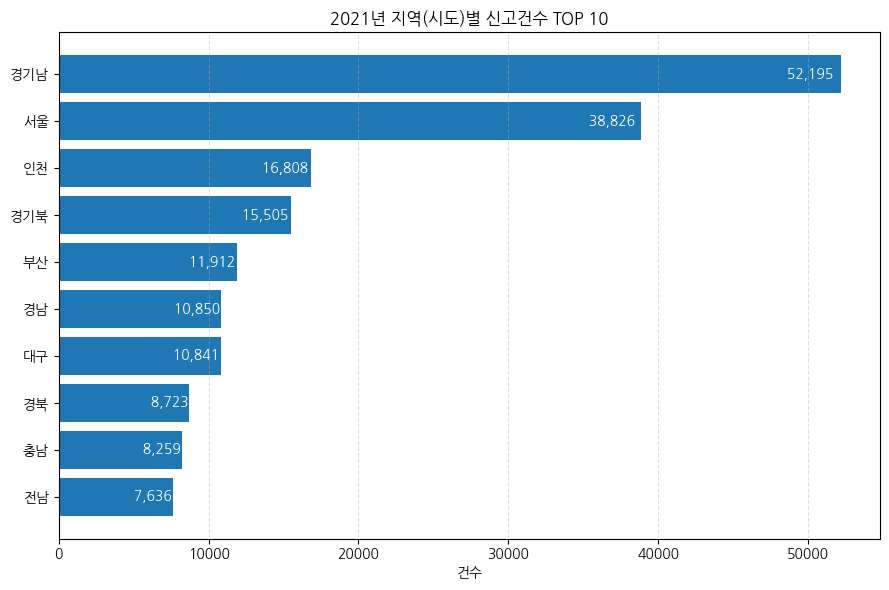

저장됨: /content/drive/MyDrive/text/violence-news-frame-analysis/processed_data/police_2021_top10_reports_by_region.png


In [ ]:
try:
    report_long
except NameError:

    report_path_try = os.path.join(OUT_P, "report_tidy.csv")
    if os.path.exists(report_path_try):
        report_long = pd.read_csv(report_long_path)
        # Ensure 'year' is numeric
        report_long['year'] = pd.to_numeric(report_long['year'], errors='coerce')
    else:

        if 'police_all' in globals():
             report_long = police_all.query("metric == 'reports'").copy()

             report_long['year'] = pd.to_numeric(report_long['year'], errors='coerce')
        else:
             raise FileNotFoundError("report_long variable is not defined and report_tidy.csv and police_all are not found.")

region_col = "item"

if region_col not in report_long.columns:

    cands = [c for c in report_long.columns if "지역" in c or "region" in c]
    if cands:
        report_long = report_long.rename(columns={cands[0]: region_col})
    else:
        raise ValueError(f"지역 컬럼 '{region_col}' 또는 유사한 컬럼을 찾을 수 없어요.")

plot_year = 2021.0

rep_2021 = (report_long.query("year == @plot_year")
                        .copy())

if "metric" in rep_2021.columns:
    rep_2021 = rep_2021[rep_2021["metric"] == "reports"]

if rep_2021.empty:
    print(f" {int(plot_year)}년의 지역별 신고건수 데이터가 없습니다.")
else:
    top10 = (rep_2021.groupby(region_col, as_index=False)["value"]
                    .sum()
                    .sort_values("value", ascending=False)
                    .head(10))

    if top10.empty:
        print(f" {int(plot_year)}년의 지역별 신고건수 데이터가 없어 TOP 10을 생성할 수 없습니다.")
    else:
        plt.figure(figsize=(9, 6))
        bars = plt.barh(top10[region_col], top10["value"], color="#1f77b4")
        plt.gca().invert_yaxis()
        plt.title(f"{int(plot_year)}년 지역(시도)별 신고건수 TOP 10")
        plt.xlabel("건수")

        for y, v in enumerate(top10["value"]):
            plt.text(v * 0.99, y, f" {int(v):,}", va="center", ha="right", fontsize=10, color="white") # Adjusted text position and color

        plt.grid(axis="x", linestyle="--", alpha=0.4)
        plt.tight_layout()

        out_png3 = os.path.join(OUT_P, f"police_{int(plot_year)}_top10_reports_by_region.png")
        plt.savefig(out_png3, dpi=150)
        plt.show()
        print("저장됨:", out_png3)